## Specificity of generated active-like molecules 
- Study how often we generate molecules with Morgan dice similarity to one of the ExCAPE hits (Excape_agonists_with_LargeConsistentlyEnrichedScafolds.csv) above several thresholds conditioned on profiles from several overexpressed genes (including those with available ExCAPE agonists and the top 10 most differentiable genes)
- Test statistical significance of active-like counts using Fisher t-test
- Publication **Figure 4a**

In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", 50)
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
from tqdm import tqdm
import pickle
import scipy.stats as stats

import logging 
logging.basicConfig(level=logging.INFO, format ='%(levelname)s - %(message)s')

import cpmolgan.utils as utils
import cpmolgan.nearest_neighbors as nn


## Inputs

In [2]:
args = {
    'ecfp_sim_thresholds': [0.6,0.7,0.8],
    'repetitions': ["n1","n2","n3"],
    'p-value': 0.001, 
    'results_dir': 'results',
    'figures_dir': 'figures',
    'Excape_hits_filename':'results/scafold_analysis/Excape_agonists_with_LargeConsistentlyEnrichedScafolds.csv',
    'generated_ref_dir':"REP_Valid_PassPhysChemFilter/generated_mols",
    'generated_ref_filename':"GENE__20000_Valid_PassPhysChemFilter.csv",
    'top_10_diff_genes': ['RAF1', 'JUN', 'ATF4', 'BRAF', 'CEBPA', 'RELB', 'MEK1', 'PIK3CD','AKT3', 'WWTR1'],
    'Excape_genes':['DMSO',"TP53","BRCA1","NFKB1","HSPA5", "CREBBP", "STAT1", "STAT3","HIF1A", "NFKBIA"]
                  #   0      1      2        3        4         5        6       7        8       9      10      11 
}

args['output_filename_hit_counts']=args['Excape_hits_filename'].replace('.csv','__HitCounts_AllGenes_3SimThresh.csv')

## 1. Read Excape agonists with enriched scafolds

In [3]:
Excape_hits = pd.read_csv(args['Excape_hits_filename'],index_col=0)
Excape_hits["ecfp"] = nn.smiles_to_ecfps_parallel( Excape_hits.SMILES_standard_Excape.values )

## 2. Load generated molecules and compute simmilarity matrix to Ecape hits
Takes long zzzz

In [4]:
if not os.path.isfile(args['output_filename_hit_counts']):
    
    # Read generated molecules for all genes and all repetitions
    all_cond_genes = args['Excape_genes'] + args['top_10_diff_genes']
    generated_cpds = pd.DataFrame()
    logging.info("Loading generated molecules and computing fingerprints")
    for oe_gene in tqdm(all_cond_genes):    
        ref_OE_file = os.path.join( args['results_dir'], args["generated_ref_dir"], args["generated_ref_filename"].replace("GENE", oe_gene) ) 
        gene_df = pd.DataFrame()
        for rep in args['repetitions']:
            gene_df = pd.concat( [ gene_df, pd.read_csv( ref_OE_file.replace("REP",rep), index_col=0 ) ] )        
        gene_df["ecfp"]  = nn.smiles_to_ecfps_parallel( gene_df.SMILES_standard.values )
        generated_cpds = pd.concat([generated_cpds,gene_df])
    generated_cpds = generated_cpds.reset_index(drop=True)

    logging.info("Computing sim matrix")
    sim_mat = nn.dice_similairty_matrix( Excape_hits.ecfp.values, generated_cpds.ecfp.values)

## 3. Compute counts
- How often we get close to the excape hit when conditioning on each gene
- To keep it more open, we compute it for 3 different simmilarity thresholds

In [5]:
if not os.path.isfile(args['output_filename_hit_counts']):
    print('Computing counts')

    Excape_hit_counts =  pd.DataFrame()
    for sim_thresh in args['ecfp_sim_thresholds']:
        for Excape_idx in range(len(Excape_hits)):

            # Compute counts
            total_counts = pd.DataFrame( generated_cpds['Gene_Symbol'].value_counts().reset_index())
            total_counts = total_counts.rename( columns={'index':'Gene_Symbol','Gene_Symbol':'total_counts'})
            hit_counts = pd.DataFrame(generated_cpds['Gene_Symbol'])
            hit_counts['is_simmilar'] = sim_mat[Excape_idx,:]>= sim_thresh
            hit_counts = hit_counts.groupby(by='Gene_Symbol').sum().reset_index()
            hit_counts = hit_counts.merge(total_counts)
            hit_counts = hit_counts.rename(columns={'is_simmilar':'hit_counts',
                                                   'Gene_Symbol':'Gene_Symbol_cond'})
            
            # Merge data from Excape hit
            hit_counts['sim_threshold'] = sim_thresh
            hit_counts['SMILES_standard_Excape'] =  Excape_hits.loc[Excape_idx,'SMILES_standard_Excape']
            hit_counts = hit_counts.merge( Excape_hits , on='SMILES_standard_Excape')
            hit_counts = hit_counts.rename(columns={'Gene_Symbol':'Gene_Symbol_Excape'}).drop(columns=['ecfp','multiple_targets'])

            # Sort genes and add to full df 
            idx = dict(zip(all_cond_genes, range(len(all_cond_genes))))
            hit_counts['rank'] = hit_counts['Gene_Symbol_cond'].map(idx)
            hit_counts = hit_counts.sort_values(by='rank').reset_index(drop=True).drop(columns=['rank'])
            Excape_hit_counts = pd.concat( [Excape_hit_counts,hit_counts])

    # Format full df and save
    Excape_hit_counts = Excape_hit_counts.reset_index(drop=True)
    Excape_hit_counts = Excape_hit_counts[ ['Excape_hit_name','Gene_Symbol_Excape','Gene_Symbol_cond',
                                            'hit_counts','total_counts','sim_threshold','SMILES_standard_Excape','murcko_scafold']]
    Excape_hit_counts.to_csv(args['output_filename_hit_counts'])
else:
    print('loading counts from %s'%args['output_filename_hit_counts'])
    Excape_hit_counts = pd.read_csv(args['output_filename_hit_counts'], index_col=0)

loading counts from results/scafold_analysis/Excape_agonists_with_LargeConsistentlyEnrichedScafolds__HitCounts_AllGenes_3SimThresh.csv


## 4. Plot counts 

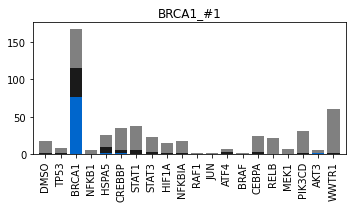

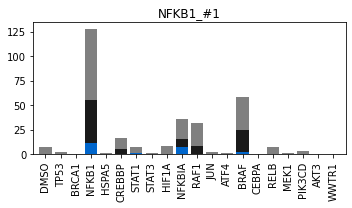

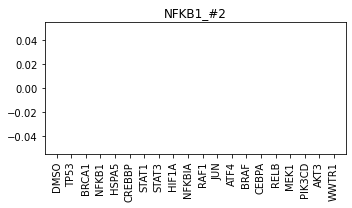

In [6]:
colors = [ [ 0.5,0.5,0.5], [0.1,0.1,0.1], [0,0.4,0.8]]

# To exlcude genes with low excape agonists which were skkiped in the publication
plot_genes = args['Excape_genes'] + args['top_10_diff_genes'] 

for Excape_hit in Excape_hit_counts.Excape_hit_name.unique():
    fig = plt.figure(figsize=(5,3))
    for s, sim_thres in enumerate(Excape_hit_counts.sim_threshold.unique()):
        idx = (Excape_hit_counts.Excape_hit_name==Excape_hit)&(Excape_hit_counts.sim_threshold==sim_thres)
        idx = idx & Excape_hit_counts.Gene_Symbol_cond.isin(plot_genes)
        plot_df = Excape_hit_counts.loc[idx]
        x = np.array(range(len(plot_df)))#+0.3*s
        y = plot_df.hit_counts        
        plt.bar(x, y, align='center', alpha=1, color = colors[s]) 
        plt.xticks(x, labels=plot_df.Gene_Symbol_cond.values, rotation=90)
        plt.xlim([-0.8,19.8])
        plt.title(Excape_hit)
        plt.tight_layout()
        
    plt.show()
    filename = os.path.join( args['figures_dir'], 'ExcapeHit_'+Excape_hit+'_counts_AllGenes.pdf')
    fig.savefig(filename)
    

## 5. Fisher t-tests

### 5.1 Selected gene vs all other genes and DMSO together

In [7]:
fisher_vs_all_genes = pd.DataFrame()
cap_negatives = True

for Excape_hit in Excape_hit_counts.Excape_hit_name.unique():
    for s, sim_thres in enumerate(Excape_hit_counts.sim_threshold.unique()):
        
        # Get data for current hit and threshold
        idx = (Excape_hit_counts.Excape_hit_name==Excape_hit)&(Excape_hit_counts.sim_threshold==sim_thres)
        df = Excape_hit_counts.loc[idx].reset_index(drop=True)
        ref_gene = df.Gene_Symbol_Excape.unique()[0]
        ref_idx = df.Gene_Symbol_cond==ref_gene
        other_idx = ref_idx == False

        if cap_negatives:
            cap_value = 200
            df['total_counts'] = cap_value
            message = "Could not cap total counts since one of the genes has higher counts than the cap"
            assert (df['hit_counts'].max() < cap_value), message
            
        # Create contingency matrix to test enrichment of reference gene vs all other genes + DMSO
        cont_mat = pd.DataFrame(index=['hit','no_hit'],columns=['ref_gene','all_other_genes'])
        cont_mat.loc['hit','ref_gene'] = df.loc[ ref_idx, 'hit_counts' ].sum()
        cont_mat.loc['no_hit','ref_gene'] = df.loc[ ref_idx,'total_counts'].sum() - cont_mat.loc['hit','ref_gene']
        cont_mat.loc['hit','all_other_genes'] = df.loc[ other_idx, 'hit_counts' ].sum()
        cont_mat.loc['no_hit','all_other_genes'] = df.loc[ other_idx,'total_counts'].sum()- cont_mat.loc['hit','all_other_genes']

        # Fisher t-test
        _, p = stats.fisher_exact(cont_mat)
        temp_results = df.drop(columns=['Gene_Symbol_cond','hit_counts','total_counts']).drop_duplicates()
        temp_results['pValue_Fisher_t_test'] = p
        temp_results['ref_gene'] = ref_gene
        temp_results['other_genes'] =  ";".join([ i for i in df.Gene_Symbol_cond.unique() if i !=ref_gene])
        temp_results['ref_gene_proportion']=cont_mat.loc['hit','ref_gene']/cont_mat.ref_gene.sum()
        temp_results['other_genes_proportion']=cont_mat.loc['hit','all_other_genes']/cont_mat.all_other_genes.sum()
        fisher_vs_all_genes = pd.concat([fisher_vs_all_genes,temp_results])

fisher_vs_all_genes = fisher_vs_all_genes.reset_index(drop=True)

### 5.2 pairs of (Selected gene, each other gene)

In [8]:
fisher_gene_pairs = pd.DataFrame()
cap_negatives = True

for Excape_hit in Excape_hit_counts.Excape_hit_name.unique():
    for s, sim_thres in enumerate(Excape_hit_counts.sim_threshold.unique()):
        
        # Get data for current hit and threshold
        idx = (Excape_hit_counts.Excape_hit_name==Excape_hit)&(Excape_hit_counts.sim_threshold==sim_thres)
        df = Excape_hit_counts.loc[idx].reset_index(drop=True)
        ref_gene = df.Gene_Symbol_Excape.unique()[0]
        ref_idx = df.Gene_Symbol_cond==ref_gene
        
        if cap_negatives:
            cap_value = 200
            df['total_counts'] = cap_value
            message = "Could not cap total counts since one of the genes has higher counts than the cap"
            assert (df['hit_counts'].max() < cap_value), message
            
        other_genes = [ g for g in df.Gene_Symbol_cond.unique() if g !=ref_gene]
        for other_gene in other_genes:
            
            other_idx = df.Gene_Symbol_cond==other_gene
            
            # Create contingency matrix to test enrichment of reference gene vs all other genes + DMSO
            cont_mat = pd.DataFrame(index=['hit','no_hit'],columns=['ref_gene','other_gene'])
            cont_mat.loc['hit','ref_gene'] = df.loc[ ref_idx, 'hit_counts' ].sum()
            cont_mat.loc['no_hit','ref_gene'] = df.loc[ ref_idx,'total_counts'].sum() - cont_mat.loc['hit','ref_gene']
            cont_mat.loc['hit','other_gene'] = df.loc[ other_idx, 'hit_counts' ].sum()
            cont_mat.loc['no_hit','other_gene'] = df.loc[ other_idx,'total_counts'].sum()- cont_mat.loc['hit','other_gene']

            # Fisher t-test
            _, p = stats.fisher_exact(cont_mat)
            #g, p, _, _ = stats.chi2_contingency(cont_mat) # This gives the same results but throws error when there are zero counts
            temp_results = df.drop(columns=['Gene_Symbol_cond','hit_counts','total_counts']).drop_duplicates()
            temp_results['pValue_Fisher_t_test'] = p
            temp_results['ref_gene'] = ref_gene
            temp_results['other_gene'] =  other_gene
            temp_results['ref_gene_proportion']=cont_mat.loc['hit','ref_gene']/cont_mat.ref_gene.sum()
            temp_results['other_gene_proportion']=cont_mat.loc['hit','other_gene']/cont_mat.other_gene.sum()
            fisher_gene_pairs = pd.concat([fisher_gene_pairs,temp_results])

fisher_gene_pairs = fisher_gene_pairs.reset_index(drop=True)

#### Show Gene combinations with non-significant differences 

In [9]:
significant_thresh = 0.01
pd.set_option('display.max_rows', 7)
idx = (fisher_gene_pairs.pValue_Fisher_t_test > significant_thresh)
fisher_gene_pairs.loc[ idx, ['Excape_hit_name','sim_threshold','pValue_Fisher_t_test','ref_gene', 'other_gene','ref_gene_proportion','other_gene_proportion']]

,Excape_hit_name,sim_threshold,pValue_Fisher_t_test,ref_gene,other_gene,ref_gene_proportion,other_gene_proportion
103,NFKB1_#1,0.8,0.470383,NFKB1,NFKBIA,0.055,0.035
107,NFKB1_#1,0.8,0.020401,NFKB1,BRAF,0.055,0.010
114,NFKB1_#2,0.6,1.000000,NFKB1,DMSO,0.000,0.000
...,...,...,...,...,...,...,...
168,NFKB1_#2,0.8,1.000000,NFKB1,PIK3CD,0.000,0.000
169,NFKB1_#2,0.8,1.000000,NFKB1,AKT3,0.000,0.000
170,NFKB1_#2,0.8,1.000000,NFKB1,WWTR1,0.000,0.000


#### Show p-values of Gene for selected Excape hit and threshold

In [10]:
plot_hit = ['BRCA1_#1','NFKB1_#1'][1]
plot_thresh = [0.6,0.7,0.8][2]

pd.set_option('display.max_rows', 25)
idx = (fisher_gene_pairs['Excape_hit_name'] == plot_hit) & (fisher_gene_pairs.sim_threshold ==plot_thresh)
fisher_gene_pairs.loc[ idx, ['Excape_hit_name','sim_threshold','pValue_Fisher_t_test','ref_gene', 'other_gene','ref_gene_proportion','other_gene_proportion']]

,Excape_hit_name,sim_threshold,pValue_Fisher_t_test,ref_gene,other_gene,ref_gene_proportion,other_gene_proportion
95,NFKB1_#1,0.8,0.000848,NFKB1,DMSO,0.055,0.000
96,NFKB1_#1,0.8,0.000848,NFKB1,TP53,0.055,0.000
97,NFKB1_#1,0.8,0.000848,NFKB1,BRCA1,0.055,0.000
98,NFKB1_#1,0.8,0.000848,NFKB1,HSPA5,0.055,0.000
99,NFKB1_#1,0.8,0.000848,NFKB1,CREBBP,0.055,0.000
100,NFKB1_#1,0.8,0.005644,NFKB1,STAT1,0.055,0.005
101,NFKB1_#1,0.8,0.000848,NFKB1,STAT3,0.055,0.000
102,NFKB1_#1,0.8,0.000848,NFKB1,HIF1A,0.055,0.000
103,NFKB1_#1,0.8,0.470383,NFKB1,NFKBIA,0.055,0.035
104,NFKB1_#1,0.8,0.000848,NFKB1,RAF1,0.055,0.000
